# Modos Vibracionais de Moléculas usando VASP e ASE

Autor: [Prof. Elvis do A. Soares](https://github.com/elvissoares) 

Contato: [elvis@peq.coppe.ufrj.br](mailto:elvis@peq.coppe.ufrj.br) - [Programa de Engenharia Química, PEQ/COPPE, UFRJ, Brasil](https://www.peq.coppe.ufrj.br/)

---

Importando variáveis do VASP

In [1]:
import os
# Definindo o path para os arquivos de potencial de pseudopotenciais do VASP
# Certifique-se de que o caminho esteja correto para o seu sistema
os.environ['VASP_PP_PATH'] = '/home/elvis/Programs/vasp-6.5.1/pp'
os.environ['ASE_VASP_COMMAND'] = 'mpirun -np 1 vasp_std_gpu'
os.environ['NO_STOP_MESSAGE'] = '1' # to avoid warning from mpirun

# Importando o VASP calculator do ASE
from ase.calculators.vasp import Vasp

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ase.io import write, read
from ase.visualize import view
from ase.build import molecule

## Passos para determinar Vibrações

1. Relaxar Geometria da molécula ou sólido
2. Calcular modos vibracionais usando VASP

## Relaxando Geometria da Água

In [3]:
# Criando molecula de agua
water = molecule('H2O')
water.center(vacuum=6.0) 
water.pbc = True 

# See basic info
print(water)
print('Número de átomos:', len(water))
print("Cell:", water.get_cell())

Atoms(symbols='OH2', pbc=True, cell=[12.0, 13.526478000000001, 12.596309])
Número de átomos: 3
Cell: Cell([12.0, 13.526478000000001, 12.596309])


In [4]:
view(water, viewer='x3d')

In [5]:
calc = Vasp(
            directory='water/relaxed',
            xc='PBE',
            encut=450,                # safe PAW-PBE default
            kpts=[1, 1, 1], gamma=True,
            ismear=0, sigma=0.05,     # Gaussian smearing for molecules
            ediff=1e-6, ediffg=-0.02, # SCF and force criteria (~0.02 eV/Å)
            ibrion=2, isif=0, nsw=150,# CG ionic relax; fixed cell
            lreal='Auto',
            lwave=True, lcharg=True,lvtot=True,  # keep WAVECAR/CHGCAR/LOCPOT for post-processing
            atoms=water
        )

calc.calculate(water) # doing all the calculations

In [6]:
E_wat = water.get_potential_energy()   

print('Energia da água relaxada: {:.3f} eV'.format(E_wat))

Energia da água relaxada: -14.220 eV


In [7]:
print("Número de passos executados:", calc.read_number_of_ionic_steps())

Número de passos executados: 5


In [8]:
write('water_relaxed.pdb', water)

## Calculando frequências de vibração

In [9]:
calc = Vasp(restart=True,directory='water/relaxed')
water = calc.get_atoms()

In [10]:
# now define a new calculator
calc = Vasp(directory="water/vib_dfpt",
        xc="PBE",
        encut=450,
        ismear=0, sigma=0.05,   # Gaussian smearing
        ibrion=7,               # switches on the DFPT vibrational analysis (with no symmetry constraints)
        nfree=2, 
        lepsilon=True,            # enables to calculate and to print the BEC
        # tensors
        lreal=False,
        nsw=1,
        nwrite=3,                 # affects OUTCAR verbosity: explicitly forces
        ldipol=True, 
        idipol = 4,            # full 3D dipole (molecules)
        dipol=water.get_center_of_mass(scaled=True), # dipole position is CM
        atoms=water)

In [11]:
calc.calculate(water) # doing all the calculations

Demorou 2m 35s

Determinando o momento de dipolo elétrico

In [12]:
water_dipole = calc.read_dipole()

print("Momento de dipolo elétrico da água:", water_dipole, "e.A")
print("Magnitude (Debye):", (sum(x**2 for x in water_dipole)**0.5) * 4.80321)

Momento de dipolo elétrico da água: [0.     0.     0.3794] e.A
Magnitude (Debye): 1.822337874


Determinando as frequências de vibração

In [13]:
vib_freq = calc.read_vib_freq()

for i, f in enumerate(vib_freq[0]):
    print("{0:02d}: {1} meV".format(i, f))

00: 476.153354 meV
01: 462.023793 meV
02: 195.927543 meV
03: 13.057206 meV
04: 11.862163 meV
05: 6.172978 meV
06: 476.153354 meV
07: 462.023793 meV
08: 195.927543 meV
09: 13.057206 meV
10: 11.862163 meV
11: 6.172978 meV


Definindo classe `VibrationsData` do ASE

In [14]:
vib_water = calc.get_vibrations()

In [15]:
freq = vib_water.get_frequencies()

for i, f in enumerate(freq):
    print("{0:01d}: {1} cm-1".format(i, f))

0: 226.66198477009652j cm-1
1: 82.29404504874357j cm-1
2: 10.249636598821873j cm-1
3: (49.788449953511446+0j) cm-1
4: (95.67483715543133+0j) cm-1
5: (105.31351704759376+0j) cm-1
6: (1580.2629167680952+0j) cm-1
7: (3726.47488464953+0j) cm-1
8: (3840.4375261819296+0j) cm-1


Exportando GIFs com os modos de vibração

/home/elvis/Programs/miniforge3/envs/quantum/lib/python3.13/site-packages/ase/visualize/plot.py:51: UserWarning: frames=<generator object VibrationsData.iter_animated_mode at 0x7f03c2105120> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  animation = FuncAnimation(fig, drawimage, frames=images,
/home/elvis/Programs/miniforge3/envs/quantum/lib/python3.13/site-packages/ase/visualize/plot.py:51: UserWarning: frames=<generator object VibrationsData.iter_animated_mode at 0x7f0498af4a60> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  animation = F

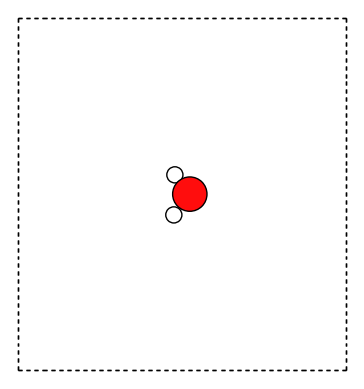

In [16]:
for i, f in enumerate(freq):
    write(f"water_vib_mode{i:01d}.gif", vib_water.iter_animated_mode(i), rotation="0x,90y,0z", interval=100) 

In [17]:
from IPython.display import HTML, display

gif_files = [
    "water_vib_mode0.gif", "water_vib_mode1.gif", "water_vib_mode2.gif",
    "water_vib_mode3.gif", "water_vib_mode4.gif", "water_vib_mode5.gif",
    "water_vib_mode6.gif", "water_vib_mode7.gif", "water_vib_mode8.gif"
]

# Build an HTML table with gifs
rows = []
for i in range(0, 9, 3):
    row = "".join([f'<td><img src="{gif}" width="500"></td>' for gif in gif_files[i:i+3]])
    rows.append(f"<tr>{row}</tr>")

html_code = f"<table>{''.join(rows)}</table>"

display(HTML(html_code))

,,
,,
,,


## Molécula de CO2

In [18]:
# Criando molecula
co2 = molecule('CO2')
co2.center(vacuum=6.0) 
co2.pbc = True 

# See basic info
print(co2)
print('Número de átomos:', len(co2))
print("Cell:", co2.get_cell())

Atoms(symbols='CO2', pbc=True, cell=[12.0, 12.0, 14.357316])
Número de átomos: 3
Cell: Cell([12.0, 12.0, 14.357316])


In [19]:
calc = Vasp(
            directory='co2/relaxed',
            xc='PBE',
            encut=450,                # safe PAW-PBE default
            kpts=[1, 1, 1], gamma=True,
            ismear=0, sigma=0.05,     # Gaussian smearing for molecules
            ediff=1e-6, ediffg=-0.02, # SCF and force criteria (~0.02 eV/Å)
            ibrion=2, isif=0, nsw=150,# CG ionic relax; fixed cell
            lreal='Auto',
            lwave=True, lcharg=True,lvtot=True,  # keep WAVECAR/CHGCAR/LOCPOT for post-processing
            atoms=co2
        )

calc.calculate(co2) # doing all the calculations

In [20]:
E_co2 = co2.get_potential_energy()   

print('Energia do CO2 relaxado: {:.3f} eV'.format(E_co2))

Energia do CO2 relaxado: -22.961 eV


In [21]:
calc = Vasp(restart=True,directory='co2/relaxed')
co2 = calc.get_atoms()

# now define a new calculator
calc = Vasp(directory="co2/vib_dfpt",
        xc="PBE",
        encut=450,
        ismear=0, sigma=0.05,   # Gaussian smearing
        ibrion=7,               # switches on the DFPT vibrational analysis (with no symmetry constraints)
        nfree=2,
        lepsilon=True,            # enables to calculate and to print the BEC
        # tensors
        lreal=False,
        nsw=1,
        nwrite=3,                 # affects OUTCAR verbosity: explicitly forces
        ldipol=True, 
        idipol = 4,            # full 3D dipole (molecules)
        dipol=co2.get_center_of_mass(scaled=True), # dipole position is CM
        atoms=co2)

calc.calculate(co2) # doing all the calculations

In [22]:
dipole = calc.read_dipole()

print("Dipole moment (e·Å):", dipole)
print("Magnitude (Debye):", (sum(x**2 for x in dipole)**0.5) * 4.80321)

Dipole moment (e·Å): [1.2e-05 1.2e-05 1.0e-06]
Magnitude (Debye): 8.165457e-05


Pegando informações da vibração

In [23]:
vib_co2 = calc.get_vibrations()

In [24]:
freq = vib_co2.get_frequencies()

for i, f in enumerate(freq):
    print("{0:01d}: {1} cm-1".format(i, f))

0: 43.11883028490094j cm-1
1: 43.11883006528274j cm-1
2: 8.562999618020765j cm-1
3: 8.550966857729442j cm-1
4: 3.118862102731979j cm-1
5: (631.654551056656+0j) cm-1
6: (631.654562841128+0j) cm-1
7: (1317.3523463124866+0j) cm-1
8: (2365.3864808186+0j) cm-1


Exportando os GIFs de cada modo de vibração

/home/elvis/Programs/miniforge3/envs/quantum/lib/python3.13/site-packages/ase/visualize/plot.py:51: UserWarning: frames=<generator object VibrationsData.iter_animated_mode at 0x7f03c2104ee0> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  animation = FuncAnimation(fig, drawimage, frames=images,
/home/elvis/Programs/miniforge3/envs/quantum/lib/python3.13/site-packages/ase/visualize/plot.py:51: UserWarning: frames=<generator object VibrationsData.iter_animated_mode at 0x7f03c21056c0> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  animation = F

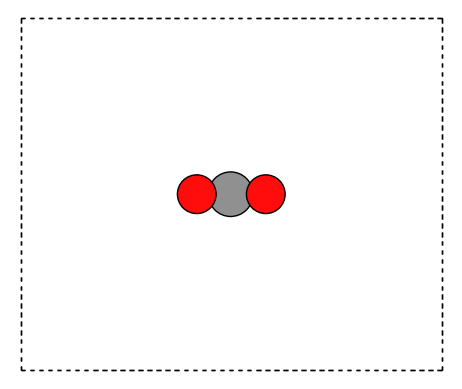

In [25]:
for i, f in enumerate(freq):
    write(f"co2_vib_mode{i:01d}.gif", vib_co2.iter_animated_mode(i), rotation="0x,90y,0z", interval=100) 

In [26]:
gif_files = [
    "co2_vib_mode0.gif", "co2_vib_mode1.gif", "co2_vib_mode2.gif",
    "co2_vib_mode3.gif", "co2_vib_mode4.gif", "co2_vib_mode5.gif",
    "co2_vib_mode6.gif", "co2_vib_mode7.gif", "co2_vib_mode8.gif"
]

# Build an HTML table with gifs
rows = []
for i in range(0, 9, 3):
    row = "".join([f'<td><img src="{gif}" width="400"></td>' for gif in gif_files[i:i+3]])
    rows.append(f"<tr>{row}</tr>")

html_code = f"<table>{''.join(rows)}</table>"

display(HTML(html_code))

,,
,,
,,


In [27]:
co2.get_moments_of_inertia() # amu.A^2

array([-3.55271368e-15,  4.42969445e+01,  4.42969445e+01])

In [28]:
co2.get_masses()

array([12.011, 15.999, 15.999])